In [12]:
from nbdev import *

In [13]:
#| default_exp core

# Core module

> API details.

In [14]:
#|hide
from nbdev.showdoc import *

In [15]:
#|export
from scip_workflows.common import *

In [16]:
#|export
import sys
import yaml
import sqlite3
import math
import tifffile
import zarr
from aicsimageio import AICSImage

from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec

from scip.masking import threshold, remove_regions_touching_border

import multiprocessing
import math

# Utility function for saving gating in SQLite database

In [8]:
#|export
def load_from_sqlite_db(path, gate=None):
    with sqlite3.connect(path) as con:

        if gate is None:
            df = pandas.read_sql_query("""
                SELECT * from data
            """, con)
        else:
            df = pandas.read_sql_query("""
                SELECT * from data
                INNER JOIN gates ON data.meta_id = gates.meta_id AND data.meta_file = gates.meta_file
                WHERE %s = 1
            """ % gate, con)

    df = df.loc[:,~df.columns.duplicated()]
    df["meta_replicate"] = df["meta_file"].apply(lambda a: a.split("_")[0])
    df["meta_timepoint"] = df["meta_file"].apply(lambda a: int(a.split("_")[1][1:]))
    df["meta_fiji"] = df["meta_id"]*2+1

    return df

def add_gating_table(path):
    with sqlite3.connect(path) as con:
        return con.execute(f"""
        CREATE TABLE IF NOT EXISTS gates (
            meta_id BIGINT NOT NULL,
            meta_file VARCHAR NOT NULL,
            PRIMARY KEY (meta_id,meta_file),
            FOREIGN KEY (meta_id,meta_file) REFERENCES data(meta_id,meta_file)
        )""")

def add_gate(path, name, df):
    with sqlite3.connect(path) as con:
        if "meta_"+name not in [i[1] for i in con.execute('PRAGMA table_info(gates)')]:
            con.execute("ALTER TABLE gates ADD COLUMN meta_%s INTEGER DEFAULT 0" % name)
        return con.executemany(f"""
            INSERT INTO gates (meta_id, meta_file, meta_%s) VALUES (:meta_id, :meta_file, 1)
            ON CONFLICT (meta_id, meta_file)
            DO UPDATE SET meta_%s = 1
        """ % (name, name), df[["meta_id", "meta_file"]].to_dict(orient="records"))

In [136]:
c = add_gating_table("data/sc_gate_allCtrl.sqlite3")

In [137]:
c = add_gate("data/sc_gate_allCtrl.sqlite3", "gate1", pandas.DataFrame([("C3_T5_69.cif", "0"), ("C3_T5_69.cif", "1")], columns=["meta_file", "meta_id"]))
c.rowcount

2

In [138]:
c = add_gate("data/sc_gate_allCtrl.sqlite3", "gate2", pandas.DataFrame([("C3_T5_69.cif", "3")], columns=["meta_file", "meta_id"]))
c.rowcount

1

In [139]:
load_from_sqlite_db("data/sc_gate_allCtrl.sqlite3", "gate1")

,feat_min_0,feat_haralickEntropyHORIZONTAL_5,feat_min_6,feat_haralickEntropyHORIZONTAL_6,feat_min_3,feat_min_5,feat_haralickEntropyVERTICAL_6,feat_haralickEntropyHORIZONTAL_0,feat_haralickEntropyVERTICAL_5,feat_haralickEntropyHORIZONTAL_3,...,feat_haralickContrastHORIZONTAL_0,feat_max_5,feat_tamuraContrast_10,gate1,gate2,meta_gate1,meta_gate2,meta_replicate,meta_timepoint,meta_fiji
0,745,4.661803,37,4.873306,25,26,4.891705,4.957409,4.918806,3.581225,...,332.692771,81,24.374255,1,0,1,0,C3,5,1
1,671,4.319667,31,5.463857,23,25,5.452105,5.543997,4.681868,4.285808,...,170.860215,297,56.560989,1,0,1,0,C3,5,3
2,756,4.778958,40,4.661738,23,24,4.695771,4.985134,4.886545,4.183226,...,366.601307,101,24.822255,1,1,0,1,C3,5,7
3,754,4.494071,37,4.487347,27,25,4.482653,4.703664,4.735585,3.750785,...,288.737226,126,28.672292,1,0,0,0,C3,5,31
4,745,4.376188,32,4.594803,24,25,4.545932,4.827261,4.602216,3.882469,...,276.639706,177,34.724980,1,0,0,0,C3,5,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156106,738,3.754506,44,5.026107,16,26,4.984516,5.044493,4.267118,4.603163,...,295.134715,286,28.620163,1,0,0,0,C2,4,39807
156107,741,4.060872,51,4.891718,10,26,4.803898,4.996986,4.581849,4.558410,...,307.300613,172,24.805000,1,0,0,0,C2,4,39681
156108,750,4.423048,35,5.088294,28,25,5.145053,4.951453,4.772655,3.532873,...,239.284211,214,9.371372,1,0,0,0,C2,4,39981
156109,748,3.541067,46,5.032592,8,25,5.165129,5.198609,4.111942,4.908994,...,368.654378,258,32.217527,1,0,0,0,C2,4,39579


# UMAP utility functions

In [9]:
#|export
def do_umap(name, data, **umap_args):
    projector = umap.UMAP(**umap_args)
    projection = projector.fit_transform(data)
    projection = pandas.DataFrame(projection, columns=["dim_%d" % i for i in range(1, projector.get_params()["n_components"]+1)])
    dump(projection, "data/umap/%s.dat" % name)

In [1]:
#|export
from matplotlib.widgets import PolygonSelector
import matplotlib.path

class SelectFromCollection:
    def __init__(self, ax, collection):
        self.canvas = ax.figure.canvas
        self.collection = collection

        self.xys = collection.get_offsets()
        self.Npts = len(self.xys)

        self.lasso = PolygonSelector(ax, onselect=self.onselect)
        self.populations = []

    def onselect(self, verts):
        path = matplotlib.path.Path(verts)
        self.populations.append(numpy.nonzero(path.contains_points(self.xys))[0])
        self.canvas.draw_idle()

    def disconnect(self):
        self.lasso.disconnect_events()
        self.canvas.draw_idle()

In [ ]:
#|export
def color_dimred(dimred, feat):
    fig, ax = plt.subplots(dpi=150)
    norm = Normalize(vmin=feat.quantile(0.01), vmax=feat.quantile(0.99))
    seaborn.scatterplot(x=dimred[:, 0], y=dimred[:, 1], s=0.5, alpha=0.5, edgecolors="none", palette="viridis", hue_norm=norm, legend=None, hue=feat, ax=ax)
    ax.set_axis_off()
    ax.set_title(feat.name)
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    ax.figure.colorbar(sm, shrink=0.7)
    return ax

# Plot manual gate images

In [1]:
#|export
def plot_gate(sel, df, maxn=200, sort=None):
    df = df.loc[sel]

    if len(df) > maxn:
        df = df.sample(n=maxn)

    if sort is not None:
        df = df.sort_values(by=sort)

    fig, axes = plt.subplots(ncols=10, nrows=int(math.ceil(len(df) / 10)), dpi=150)
    axes = axes.ravel()
    for (idx, r), ax in zip(df.iterrows(), axes[:len(df)]):
        pixels = tifffile.imread(r["meta_1"], key=0)
        minr, minc, maxr, maxc = int(r["meta_bbox_minr"]), int(r["meta_bbox_minc"]), int(r["meta_bbox_maxr"]), int(r["meta_bbox_maxc"])

        ax.imshow(pixels[minr:maxr, minc:maxc])
        ax.set_axis_off()
    for ax in axes[len(df):]:
        ax.set_axis_off()

In [1]:
#|export
def plot_gate_zarr(sel, df, maxn=200, sort=None, channel=0):
    df = df.loc[sel]

    if len(df) > maxn:
        df = df.sample(n=maxn)

    if sort is not None:
        df = df.sort_values(by=sort)

    fig, axes = plt.subplots(ncols=10, nrows=int(math.ceil(len(df) / 10)), dpi=150)
    axes = axes.ravel()
    i = 0
    for path, gdf in df.groupby("meta_path"):
        z = zarr.open(path, mode="r")
        for (idx, r) in gdf.iterrows():
            ax = axes[i]
            pixels = z[r["meta_zarr_idx"]]
            pixels = pixels.reshape(z.attrs["shape"][r["meta_zarr_idx"]])[channel]
            minr, minc, maxr, maxc = int(r["meta_bbox_minr"]), int(r["meta_bbox_minc"]), int(r["meta_bbox_maxr"]), int(r["meta_bbox_maxc"])

            ax.imshow(pixels[minr:maxr, minc:maxc])
            ax.set_axis_off()

            i+=1
    for ax in axes[len(df):]:
        ax.set_axis_off()

In [1]:
#|export
def plot_gate_zarr_channels(selectors, df, maxn=20, sort=None, mask=False, main_channel=3, smooth=0.75, channel_ind=[0], channel_names=["c"]):

    dfs = []
    for i, sel in enumerate(selectors):
        tmp_df = df[sel].copy()

        if len(tmp_df) > maxn:
            tmp_df = tmp_df.sample(n=maxn)

        if sort is not None:
            tmp_df = tmp_df.sort_values(by=sort)

        tmp_df["sel"] = i
        dfs.append(tmp_df)
    df = pandas.concat(dfs)

    nchannels = len(channel_ind)

    images = {}
    masks = {}
    values = {}
    extent = numpy.empty(shape=(nchannels, 2), dtype=float)
    extent[:, 0] = numpy.inf
    extent[:, 1] = -numpy.inf

    for path, gdf in df.groupby("meta_path"):
        z = zarr.open(path, mode="r")
        for (idx, r) in gdf.iterrows():
            pixels = z[r["meta_zarr_idx"]]
            pixels = pixels.reshape(z.attrs["shape"][r["meta_zarr_idx"]])[channel_ind]

            m = threshold.get_mask(dict(pixels=pixels), main_channel=main_channel, smooth=smooth)
            m = remove_regions_touching_border(m, bbox_channel_index=main_channel)

            minr, minc, maxr, maxc = int(r["meta_bbox_minr"]), int(r["meta_bbox_minc"]), int(r["meta_bbox_maxr"]), int(r["meta_bbox_maxc"])

            arr = m["mask"][:, minr:maxr, minc:maxc]
            masks[r["sel"]] = masks.get(r["sel"], []) + [numpy.where(arr, numpy.nan, arr)]
            images[r["sel"]] = images.get(r["sel"], []) + [m["pixels"][:, minr:maxr, minc:maxc]]

            p =  numpy.where(arr, pixels[:, minr:maxr, minc:maxc], numpy.nan)
            extent[:, 0] = numpy.nanmin(numpy.array([extent[:, 0], numpy.nanmin(p.reshape(nchannels, -1), axis=1)]), axis=0)
            extent[:, 1] = numpy.nanmax(numpy.array([extent[:, 1], numpy.nanmax(p.reshape(nchannels, -1), axis=1)]), axis=0)

    fig = plt.figure(dpi=75, figsize=(len(channel_ind)*2.5, len(df)*0.8))
    grid = gridspec.GridSpec(1, len(selectors), figure=fig, wspace=0.1)
    cmap = plt.get_cmap('viridis')
    norms = [Normalize(vmin=a, vmax=b) for a,b in extent]

    gs = {
        k: grid[0, k].subgridspec(len(v), nchannels)
        for k, v in images.items()
    }
    for k, v in images.items():
        for i, image in enumerate(v):
            for j, (p, m, norm) in enumerate(zip(image, masks[k][i], norms)):
                ax = plt.Subplot(fig, gs[k][i, j])
                ax.imshow(cmap(norm(p)))
                if mask:
                    ax.imshow(m, alpha=0.3, cmap="Blues")
                ax.set_axis_off()
                fig.add_subplot(ax)
                if i == 0:
                    ax.set_title(channel_names[j])

In [49]:
#|export
def plot_gate_czi(sel, df, maxn=200, sort=None, channels=[0]):
    df = df.loc[sel]

    if len(df) > maxn:
        df = df.sample(n=maxn)

    if sort is not None:
        df = df.sort_values(by=sort)

    ncols = min(df.shape[0], 5)
    nrows = int(math.ceil(len(df) / ncols))
    fig, axes = plt.subplots(
        ncols=ncols, 
        nrows=nrows, 
        dpi=50,
        figsize = (ncols*2*len(channels), nrows*2)
    )
    axes = axes.ravel()
    i = 0

    extent = numpy.full((df.shape[0], 2, len(channels)), dtype=float, fill_value=numpy.nan)
    pixels = []
    for path, gdf in df.groupby(["meta_path"]):
        ai = AICSImage(path, reconstruct_mosaic=False)
        for scene, gdf2 in gdf.groupby(["meta_scene"]):
            ai.set_scene(scene)
            for tile, gdf3 in gdf2.groupby(["meta_tile"]):
                print(tile, scene, end=" ")
                for (idx, r) in gdf3.iterrows():
                    ax = axes[i]

                    pixels_ = ai.get_image_data("CXY", Z=0, T=0, C=channels, M=tile)
                    minr, minc, maxr, maxc = int(r["meta_bbox_minr"]), int(r["meta_bbox_minc"]), int(r["meta_bbox_maxr"]), int(r["meta_bbox_maxc"])
                    
                    extent[i, 0] = pixels_[:, minr:maxr, minc:maxc].reshape(pixels_.shape[0], -1).min(axis=1)
                    extent[i, 1] = pixels_[:, minr:maxr, minc:maxc].reshape(pixels_.shape[0], -1).max(axis=1)
                    pixels.append(pixels_[:, minr:maxr, minc:maxc])
                    i+=1
                    
    min_ = extent[:, 0].min(axis=0)
    max_ = extent[:, 1].max(axis=0)
    
    for ax, pixels_ in zip(axes, pixels):
        ax.imshow(numpy.hstack((pixels_ - min_[:, numpy.newaxis, numpy.newaxis]) / (max_ - min_)[:, numpy.newaxis, numpy.newaxis]))

    for ax in axes:
        ax.set_axis_off()

In [50]:
import pickle
with open("/home/maximl/scratch/data/vsc/datasets/cd7/800/scip/150920221347/adata.pickle", "rb") as fh:
    adata = pickle.load(fh)

0 P1-D1 

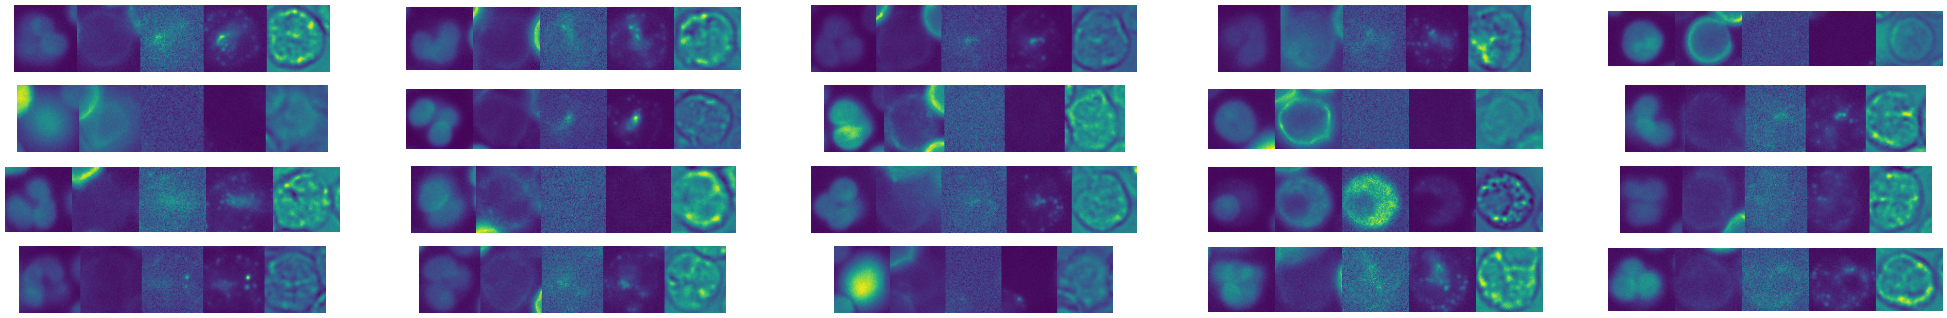

In [51]:
n=20
plot_gate_czi([True]*n, adata.obs.iloc[:n], maxn=n, channels=[0,1,2,3,4])